# Performance Metrics

In [17]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

## Load & Plot Data

In [18]:
# Read in the daily data
data_path = Path("../Resources/GOOG_implied_vol.csv")
ohlcv_df = pd.read_csv(
    data_path,
    index_col="date",
    infer_datetime_format=True,
    parse_dates=True
)

# Display sample data
ohlcv_df.head()

,open,high,low,close,average
date,,,,,
2014-04-04,0.304791,0.349954,0.297853,0.345731,0.349954
2014-04-07,0.350160,0.373892,0.344413,0.354271,0.373892
2014-04-08,0.346175,0.352271,0.335063,0.336444,0.352271
2014-04-09,0.332714,0.343556,0.331396,0.338429,0.343556
2014-04-10,0.393561,0.405006,0.385878,0.387147,0.405006


<Axes: xlabel='date'>

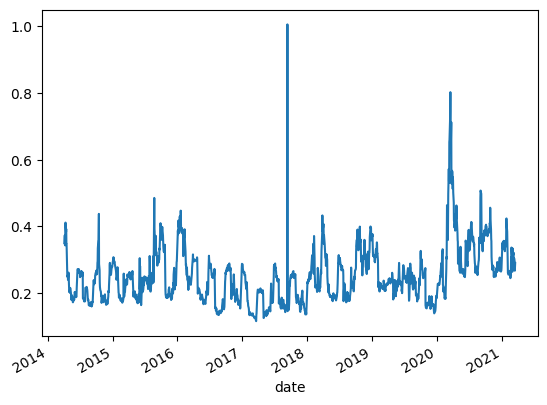

In [19]:
# Plot the data
ohlcv_df["average"].plot()

## Calculate Returns

In [20]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["average"]]

# Calculate percentage change in implied volatility 
# (Implied Volatility is a proxy for option price returns) 
signals_df["Actual Returns"] = ( signals_df["average"].pct_change())
signals_df["Actual Returns"].head()

date
2014-04-04         NaN
2014-04-07    0.068406
2014-04-08   -0.057827
2014-04-09   -0.024740
2014-04-10    0.178865
Name: Actual Returns, dtype: float64

In [21]:
# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Display sample data
signals_df.head()

,average,Actual Returns
date,,
2014-04-07,0.373892,0.068406
2014-04-08,0.352271,-0.057827
2014-04-09,0.343556,-0.024740
2014-04-10,0.405006,0.178865
2014-04-11,0.411610,0.016305


## Build a Simple Trading Algorithm

### Define a Simple Momentum Strategy

In [22]:
# Initialize the new Signal column
signals_df["Signal"] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df["Actual Returns"] >= 0), "Signal"] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df["Actual Returns"] < 0), "Signal"] = -1

### Risk and Performance

In [23]:
# Annualized volatility of the option returns for Google
annualized_volatility = round(signals_df["Actual Returns"].std() * np.sqrt(252) * 100, 2)

# Display results
print(f"Annualized Volatility: {annualized_volatility}%")

Annualized Volatility: 240.25%


In [24]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df["Strategy Returns"] = signals_df["Actual Returns"] * signals_df["Signal"].shift()

<Axes: xlabel='date'>

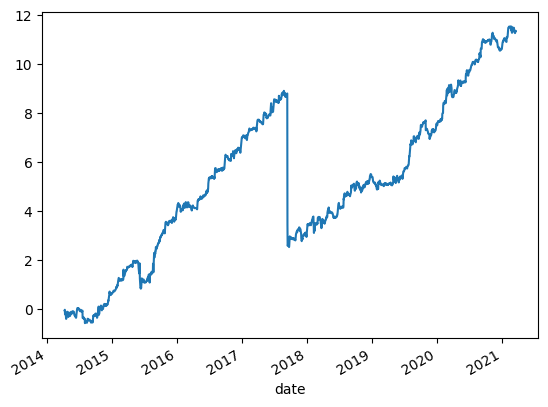

In [25]:
# Calculate the strategy's returns
strategy_returns = signals_df["Strategy Returns"].cumsum()

# Plot Strategy Returns to examine performance
strategy_returns.plot()

## Add Transaction Costs to a Backtest

In [26]:
# Every time we change from long to short, or vice-versa, 2 trades occur
signals_df["Trades"] = np.abs(signals_df["Signal"].diff())

# Display sample data
signals_df.head()

,average,Actual Returns,Signal,Strategy Returns,Trades
date,,,,,
2014-04-07,0.373892,0.068406,1.0,NaN,NaN
2014-04-08,0.352271,-0.057827,-1.0,-0.057827,2.0
2014-04-09,0.343556,-0.024740,-1.0,0.024740,0.0
2014-04-10,0.405006,0.178865,1.0,-0.178865,2.0
2014-04-11,0.411610,0.016305,1.0,0.016305,0.0


In [27]:
# Calculate total daily trade costs
cost_per_trade = 0.005
daily_trade_cost = signals_df["Trades"] * cost_per_trade
# Display sample data
daily_trade_cost.head()

date
2014-04-07     NaN
2014-04-08    0.01
2014-04-09    0.00
2014-04-10    0.01
2014-04-11    0.00
Name: Trades, dtype: float64

In [28]:
# Calculate strategy returns after costs
signals_df["Strategy Returns (After Costs)"] = signals_df['Strategy Returns'] - daily_trade_cost

### Plot the stragegy returns before and after costs

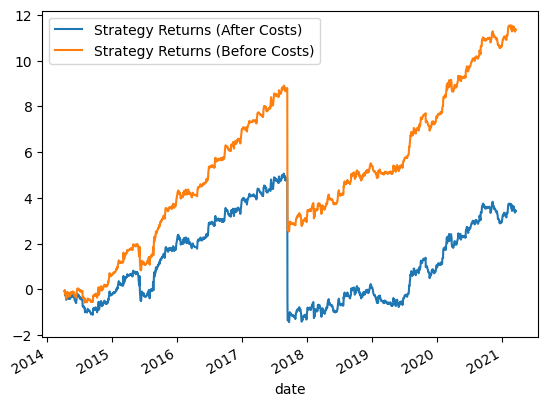

In [29]:
# Compute total strategy returns after costs
strategy_returns_after_cost = signals_df["Strategy Returns (After Costs)"].cumsum()
# Plot stategy returns before and after costs
strategy_returns_after_cost.plot(label="Strategy Returns (After Costs)")
strategy_returns.plot(label="Strategy Returns (Before Costs)")
plt.legend()

## Other Performance Metrics

### Sharpe Ratio

In [30]:
# Calculate Sharpe Ratio
annualized_returns = signals_df["Strategy Returns"].mean() * 252 
annualized_std = signals_df["Strategy Returns"].std() * np.sqrt(252)
sharpe_ratio = round(annualized_returns/annualized_returns, 3)
# Display results
print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 1.0


### Best-Case/Worst-Case Weekly Performance

<Axes: xlabel='date'>

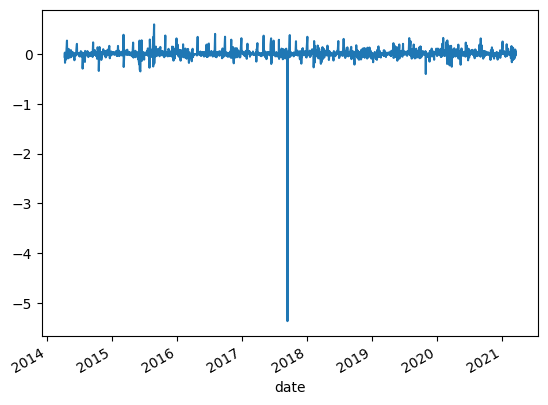

In [31]:
signals_df["Strategy Returns"].plot()

In [32]:
# Calculate weekly returns
weekly_returns = signals_df['Strategy Returns'].groupby(by=[signals_df.index.isocalendar().year, signals_df.index.isocalendar().week,]).sum()

# Display results    
weekly_returns

year  week
2014  15     -0.195647
      16     -0.206601
      17      0.228056
      18      0.026974
      19     -0.118755
                ...   
2021  7      -0.050611
      8      -0.178928
      9       0.177713
      10     -0.151651
      11      0.052924
Name: Strategy Returns, Length: 362, dtype: float64

In [33]:
# Fetch descriptive statistics
weekly_returns.describe()

count    362.000000
mean       0.031375
std        0.363875
min       -6.149959
25%       -0.048882
50%        0.027718
75%        0.128431
max        0.611968
Name: Strategy Returns, dtype: float64

<Axes: xlabel='year,week'>

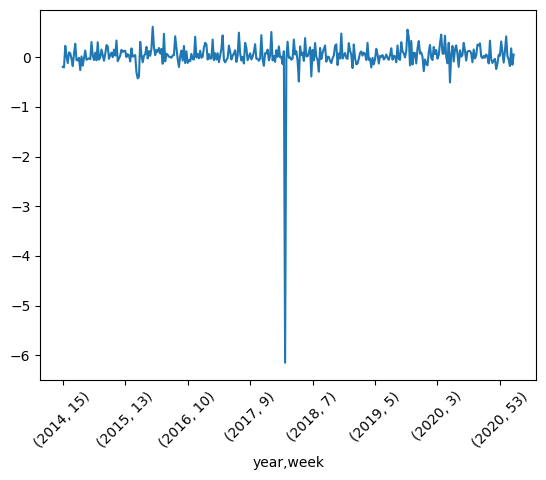

In [35]:
# Plot weekly returns
weekly_returns.plot(rot=45)